**References:**
* [Sequence to Sequence Learning with Neural Networks](https://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/)
* [Language modeling tutorial in torchtext](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
* [Language Models and Contextualised Word Embeddings](http://www.davidsbatista.net/blog/2018/12/06/Word_Embeddings/)


In [23]:
import time 
import copy
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.data import Field, BPTTIterator

from model import RNN

Define a torch.device which is used to tell PyTorch to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return True if a GPU is detected on our computer.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

`torchtext.data.Field` handles how the data should be processed, the arguments for which can be found [here](https://pytorch.org/text/data.html). We set the `tokenize` argument to "basic english". The Field also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll talk about the sentences being a sequence of tokens, instead of saying they're a sequence of words. This is because "good" and "morning" are both words and tokens, but "!" is a token, not a word.

In [3]:
# define how data should look
TEXT = Field(tokenize=get_tokenizer("basic_english"),
             init_token='<sos>',
             eos_token='<eos>',
             lower=True)

/anaconda3/envs/nlp/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Download and load the train, validation, test datasets from WikiText2.

In [4]:
# get data
train_x, val_x, test_x = WikiText2.splits(TEXT)
print(f"Number of training words:   {len(train_x.examples[0].text)}")
print(f"Number of validation words: {len(val_x.examples[0].text)}")
print(f"Number of testing words:    {len(test_x.examples[0].text)}")

/anaconda3/envs/nlp/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


Number of training words:   2086708
Number of validation words: 218177
Number of testing words:    246217


Define the hyperparameters for the model and training processs.

In [5]:
use_precomputed_embeds = False

# hyperparameters of model
embed_size = 200
rnn_hidden_size = 128
rnn_num_layers = 1
hidden_layer_size=None

# hyperparameters for training
epochs = 2
batch_size = 20
seq_len = 30
learning_rate = 1e-3
clip = 5
solver = "adam"

We next build the vocabulary for our language modelling task. The vocabulary is used to associate each unique token with an index (an integer).

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to be in our vocabulary. Tokens that appear only once are converted into an <unk> (unknown) token. Additionally, with the `vectors` argument we can use precomputed static word embeddings, in this case GloVe vectors with 200 dimensions:
    
* **Static word embeddings** map each token to a single vector, e.g. Skip-Gram (word2vec), GloVe, fastText. This means that the same word will have the same embedding regardless of the context it occurs in.
    
* **Contextual word embeddings** take into consideration the context of words, such that a word may have a different embedding depending on the words surrounding it e.g. BERT, ELMO.

In [6]:
# build vocabulary from the training data
TEXT.build_vocab(train_x, min_freq=2, vectors="glove.6B.200d" if use_precomputed_embeds else None)
vocab_size = len(TEXT.vocab.stoi)
print(f"Number of unique tokens in vocabulary: {len(TEXT.vocab)}")

Number of unique tokens in vocabulary: 28785


We now define the iterator:
* Divides the corpus into batches of sequence length => [`bppt_len`, `batch_size`].
* Does not use padding and so drops the left over data after batching.

In [7]:
train_iter, val_iter, test_iter = BPTTIterator.splits((train_x, val_x, test_x),
                                                      batch_size=batch_size,
                                                      bptt_len=seq_len,
                                                      device=device,
                                                      repeat=False)

/anaconda3/envs/nlp/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BPTTIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Initialise the Model:
* Here in the forward pass we keep the hidden state of the RNN because the entire dataset is a continuous corpus, meaning we want to retain the hidden state between sequences within a batch. 

* We can't retain the entire history as this would mean the model will try to backpropogate to the beginning of the dataset which requires a lot of memory and time. Hence we have a `repackage_hidden()` function used at the start of each batch, which treats the hidden state of the RNN from the previous batch as a constant.

* We initialise all the weights of the network from a uniform distribution, $\mathcal{U}(-0.1,0.1)$ and initialise the biases to $0$.

* Additionally, we have a `init_hidden()` function which initialises the hidden state of the RNN to a zero vector. Remember if using an LSTM then we have both the hidden state and the cell state to initialise.

In [8]:
rnn = RNN(model="lstm",
          input_size=vocab_size,
          embed_size=embed_size,
          rnn_hidden_size=rnn_hidden_size, 
          rnn_num_layers=rnn_num_layers, 
          hidden_layer_size=hidden_layer_size,
          precomputed_embeds=Text.vocab.vectors if use_precomputed_embeds else None)
print(rnn)

RNN(
  (encoder): Embedding(28785, 200)
  (rnn): LSTM(200, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=28785, bias=True)
  (relu): ReLU(inplace=True)
)


## Training

We now define the training procedure:
* We use the `torch.nn.CrossEntropyLoss` function. This loss takes the index of the correct class as the ground truth instead of a one-hot vector. Unfortunately, it only takes tensors of dimension 2 so we need to rehape our prediction and target matrices.

In [11]:
def train(model, 
          train_iter, 
          val_iter, 
          epochs, 
          batch_size, 
          seq_len, 
          learning_rate, 
          clip,
          solver,
          device):
    """
    Fit model with the training data and validate using the validation data.
    
    Parameters:
    -----------
    model : `torch.nn.Module` 
        The model.
    train_iter : `torchtext.data.iterator.BPTTIterator`
        The training data iterator.
    val_iter : `torchtext.data.iterator.BPTTIterator`
        The validation data iterator.
    batch_size : `int`
        The number of sequences per batch.
    seq_len : `int`
        The number of encoded chars in a sequence.
    learning_rate : `float`
        The learning rate.
    clip : `float`
        Value for clipping the gradients by.
    solver : `str`
        The optimiser to use, either "adam" or "sgd".
    device : `torch.device`
        Whether working on GPU or CPU.
        
    Returns:
    -------
    measures : `dict` of `list`s
        Dictionary of training and validation 
        accuracies and losses for each epoch.
    """  
    # send model to gpu or cpu
    model.to(device)
    # set model to train mode    
    model.train()        

    # initialise optimiser
    if solver.lower() == "adam": 
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif solver.lower == "sgd":
        optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # initialise loss function: cross-entropy loss
    criterion = nn.CrossEntropyLoss()     
    
    # initialise the hidden state of the RNN to zeros
    hidden = model.init_hidden(batch_size, device)       
    
    measures = defaultdict(list)
    best_model = copy.deepcopy(model)
    best_val = np.inf
    for epoch in range(epochs):
        
        start_time = time.time()
        train_loss = train_corr = 0.

        for i, batch in enumerate(train_iter):
            # detach hidden state from history
            hidden = model.repackage_hidden(hidden)            
            
            x, y = batch.text.T, batch.target.T
            
            # zero accumulated gradients
            optimiser.zero_grad()
            
            # forward Propogation: get prediction from model
            preds, hidden = model(x, hidden)         
            
            # calculate the loss
            loss = criterion(preds.reshape(-1, model.input_size), 
                             y.reshape(-1))              
       
            # backpropogation: calculating gradients
            loss.backward()
            # prevent the exploding gradient problem in RNNs/LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            # update weights
            optimiser.step()
            
            # append the train loss
            train_loss += loss.item()*x.size(0)*x.size(1)      
            # get number of tokens correct 
            preds = preds.max(2)[1].cpu().numpy()
            y = y.cpu().numpy()
            train_corr += int((preds == y).sum())  

        # set model to evaluate mode
        model.eval() 
        # get new hidden states for RNN 
        val_hidden = model.init_hidden(batch_size, device)           
        # monitor the validation loss
        val_loss = val_corr = 0.        
        with torch.no_grad():
            for j, batch in enumerate(val_iter):                    
                x, y = batch.text.T, batch.target.T
                # get validation prediction
                preds, val_hidden = model(x, val_hidden)          
                # get validaiton loss
                loss = criterion(preds.reshape(-1, model.input_size), 
                                 y.reshape(-1)) 
                # add the validation loss
                val_loss += loss.item()*x.size(0)*x.size(1)      
                # get number of tokens correct  
                preds = preds.max(2)[1].cpu().numpy()
                y = y.cpu().numpy()
                val_corr += int((preds == y).sum()) 

        # put model to train mode
        model.train()      
        
        # save losses from epoch
        train_loss /= len(train_iter.dataset.examples[0].text)
        val_loss /= len(val_iter.dataset.examples[0].text)
        measures["Train loss"].append(train_loss)
        measures["Val loss"].append(val_loss)
        # save accuracies from epoch
        train_corr /= len(train_iter.dataset.examples[0].text)
        val_corr /= len(val_iter.dataset.examples[0].text)      
        measures["Train acc"].append(train_corr)
        measures["Val acc"].append(val_corr)        
        
        print("Epoch: {}/{}...".format(epoch+1, epochs),
              "Train Loss: {:.4f}...".format(train_loss),
              "Val Loss: {:.4f}...".format(val_loss),
              "Time Taken: {:,.4f} seconds".format(time.time()-start_time))
        print("Train Acc: {:.4f}...".format(train_corr),
              "Val Acc: {:.4f}".format(val_corr)) 

        # save best model
        if measures["Val loss"][-1] < best_val:
            best_val = measures["Val loss"][-1]
            best_model = copy.deepcopy(model)
            
        # early stopping condition for convergence on validation.
        win_size = 10
        threshold = 0.00005        
        try:
            curr_avg = np.mean(measures["Val loss"][-1-win_size:-1])
            prev_avg = np.mean(measures["Val loss"][-win_size*2:-win_size])
            if np.absolute(curr_avg - prev_avg) < threshold:
                break
        except:
            pass 
    
    return best_model, measures

In [12]:
# train the model
best_model, measures = train(model=rnn, 
                             train_iter=train_iter, 
                             val_iter=val_iter, 
                             epochs=epochs, 
                             batch_size=batch_size, 
                             seq_len=seq_len, 
                             learning_rate=learning_rate, 
                             clip=clip,
                             solver=solver,
                             device=device)

Epoch: 1/2... Train Loss: 0.0030... Val Loss: 0.0282... Time Taken: 1.0481 seconds
Train Acc: 0.0000... Val Acc: 0.0000


/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


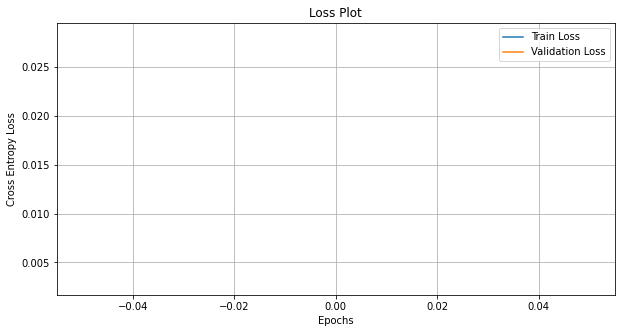

In [13]:
# Plot train and validation loss
plt.figure(figsize=(10,5))
plt.plot(measures["Train loss"], label="Train Loss")
plt.plot(measures["Val loss"], label="Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid()
plt.show()

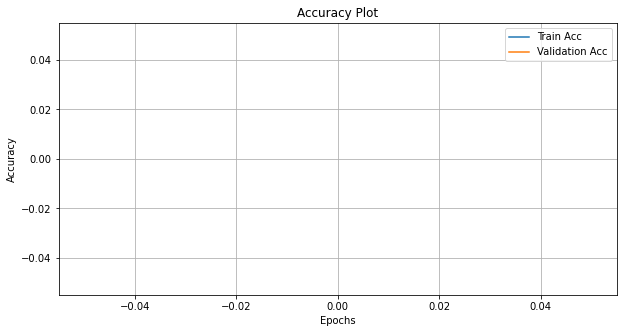

In [15]:
# Plot train and validation acc
plt.figure(figsize=(10,5))
plt.plot(measures["Train acc"], label="Train Acc")
plt.plot(measures["Val acc"], label="Validation Acc")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

## Evaluation

Evaluate the model on the test data

In [ ]:
def evaluate(model, 
             test_iter, 
             batch_size, 
             seq_len,
             device):
    """
    Evaluate model on data and calculate accuracy.
    
    Parameters:
    -----------
    model : `torch.nn.Module` 
        The model.
    test_iter : `torchtext.data.iterator.BPTTIterator`
        The test data iterator.
    batch_size : `int`
        The number of sequences per batch.
    seq_len : `int`
        The number of encoded chars in a sequence.
    device : `torch.device`
        Whether working on GPU or CPU.
        
    Returns:
    -------
    acc : `float`
        The accuracy of the model on the data predicted over
    """    
    # send model to device
    model.to(device)
    # set to evaluate mode
    model.eval()    
    
    # get new hidden state for RNN
    hidden = model.init_hidden(batch_size)          
    # accuracy stats after every epoch
    eval_corr = 0    
    for i, batch in enumerate(test_iter):
        x, y = batch.text.T, batch.target.T
        # get validation prediction
        preds, hidden = model(x, hidden)             
        # get number of tokens correct  
        preds = preds.max(2)[1].cpu().numpy()
        y = y.cpu().numpy()
        eval_corr += int((preds == y).sum())           
    acc = eval_corr / len(test_iter.dataset.examples[0].text)
    return acc

In [ ]:
train_acc = evaluate(model=best_model, 
                     test_iter=train_iter, 
                     batch_size=batch_size, 
                     seq_len=seq_len,
                     device=device)
val_acc = evaluate(model=best_model, 
                   test_iter=val_iter, 
                   batch_size=batch_size, 
                   seq_len=seq_len,
                   device=device)
test_acc = evaluate(model=best_model, 
                    test_iter=test_iter, 
                    batch_size=batch_size, 
                    seq_len=seq_len,
                    device=device)
print("Final train accuracy: ", train_acc)
print("Final val accuracy:   ", val_acc)
print("Final test accuracy:  ", test_acc)

## Interactive 

* Softmax activation function for a vector $\mathbf{z}\in\mathbb{R}^{N}$ is given by
$$\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum^{N}_{j=1}e^{z}_j}\in[0,1]$$
Thus this is useful for convert the output layer values pre-application of the activation function to probabilities.

* Sigmoid activation function for a scalar $z\in\mathbb{R}$ is given by
$$\sigma(z)=\frac{1}{1+e^{-z}}\in[0,1]$$
This can be used to convert the output value of a neural network (single output node) pre-application of the activation function to a probability. Thus used for binary classification.

In [55]:
def sample(model, 
           size, 
           device,
           prime="The", 
           top_k=None):
    """
    Given a initial sequence `prime` predicted the following 
    words.
    
    Parameters:
    -----------
    model : `torch.nn.Module`
        The recurrent network model. 
    size : `int`
        The number of tokens to predict
    device : `torch.device`
        Whether working on GPU or CPU.          
    prime : `str`
        The starting sequence to predict from.
    top_k : `int`
        The number of top tokens to draw the final token from.       
        
    Returns:
    --------
    text : `str`
        The prime with predicted next tokens.
    """
    # send model to device
    model.to(device)
    # set model to evaluate mode
    model.eval()
            
    # tokenize the prime
    tokens = TEXT.preprocess(prime)
    # get new hidden state for testing
    hidden = model.init_hidden(batch_size=1, device=device)
    # iterate through tokens in prime to build up hidden state
    for token in tokens:
        token, hidden = predict(model, token, hidden, top_k=top_k)
    # append the final token to the prime
    tokens.append(token)
    
    if size>1:
        # now pass in the previous character and get a new one
        for _ in range(size-1):
            token, hidden = predict(model, tokens[-1], hidden, top_k=top_k)
            tokens.append(token)
            
    return ' '.join(tokens)

def predict(model, 
            token, 
            hidden, 
            device,
            top_k=None):
    """
    Given a character, predict the next character
    
    Parameters:
    -----------
    model : `torch.nn.Module`
        The recurrent network model.
    token : `str`
        The previous token for which we must predict the next.
    hidden : `torch.Tensor` or `tuple`
        The hidden state of the RNN.
    device : `torch.device`
        Whether working on GPU or CPU.             
    top_k : `int`
        The number of top tokens to draw the final token from.   
        
    Returns:
    --------
    top_token : `str`
        The top token predicted by the model.
    hidden : `torch.Tensor` or `tuple`
        The hidden state of the RNN.    
    """ 
    # encode the token to an integer
    enc_x = torch.LongTensor([TEXT.vocab.stoi[token]])
    # add extra dimension to indicate batch_size of 1, [batch_size=1, seq_len=1]
    enc_x = enc_x.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # forward pass through model
        pred, hidden = model(enc_x, hidden)

    # get the character probabilities
    p = F.softmax(pred, dim=2).data.cpu()
    # get most likely characters
    if top_k is None:
        # all chars are the top chars
        top_token = np.arange(model.input_size)
    else:
        # return the prob and the top_k top_tokens 
        p, top_tokens = p.topk(top_k)
        top_tokens = top_tokens.numpy().squeeze()
    
    # select the likely next character with some element of randomness
    p = p.numpy().squeeze()
    top_token = np.random.choice(top_tokens, p=p/p.sum())
    # return the encoded value of the predicted char and the hidden state
    return TEXT.vocab.itos[top_token], hidden

In [56]:
sample(model=rnn, 
       size=1,
       device=device,
       prime="hello how", 
       top_k=5)

'hello how prejudice'